Importing necessary packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import nilearn as nl
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\nilearn\input_data\__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


Obtaining Subject ID from folder names and storing its path

In [3]:
path="D:\Documents\SEM8"
s=path+'\\Data\\COBRE\\'
ar=[]

    # folder path
dir_path = path+'\\Data\\COBRE\\'
res = []

for i in os.listdir(dir_path):
        # check if current path is a folder
    if os.path.isdir(os.path.join(dir_path, i)):
        res.append(i)
i2="\\session_1\\rest_1\\rest.nii.gz"
fn=[]
for i in res:
    x=s+i+i2
    fn.append(x)

Fromatting phenotypic file for the dataset and creating a dataframe

In [4]:
try: 
    trgt_file = path+'\\Data\\COBRE\\'+'\\Target.csv'
    r=pd.read_csv(trgt_file, header=0)
    print("Target Values file found.", trgt_file)
    y_target=r['Cat']
    age=r['Age']
    sex=r['Gen']

except:
    f=s+"COBRE_phenotypic_data.csv"
    df=pd.read_csv(f)
    df
    j=[]
    age=[]
    gender=[]
    for i in res:
        x = df[(df.SUB_ID==int(i))]
        asd =str(x["Subject_Type"])
        asd=(asd.split()[1])
        if asd=="Control":
            r=0
        else:
            r=1
        j.append(r)

        asd = str(x.iloc[:,2])
        asd=asd.split()[1]
        if asd=="Female":
            r=0
        else:
            r=1
        gender.append(r)
        
        asd = str(x.iloc[:,1])
        age.append(int(asd.split()[1]))

    y_target=pd.DataFrame(columns=['ID','Cat','Age','Gen'])
    y_target['ID']=res
    y_target['Cat']=j
    y_target['Age']=age
    y_target['Gen']=gender
    y_target.to_csv('D:\\Documents\\SEM8\\Data\\COBRE'+"\\Target.csv")

    y_target=pd.DataFrame(j)
    print(len(y_target))
        

Target Values file found. D:\Documents\SEM8\Data\COBRE\\Target.csv


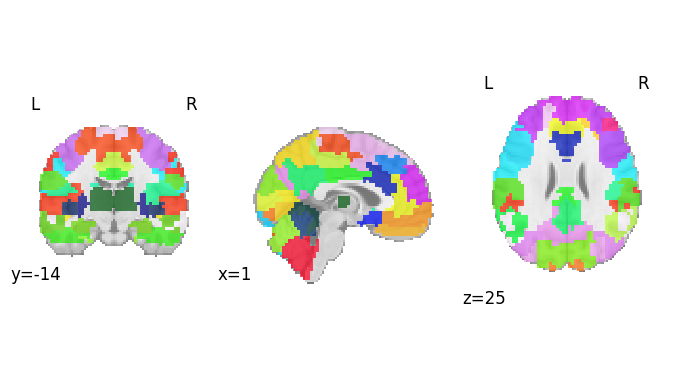

In [5]:
# visualize atlas
from nilearn import plotting
parcellations = datasets.fetch_atlas_basc_multiscale_2015(version='sym')
atlas_filename = parcellations.scale064
plotting.plot_roi(atlas_filename, draw_cross = False)

In [6]:
try: # check if feature file already exists
        # load features
    feat_file = (path+'\\Data\\COBRE\\'+ 'COBRE_features.npz')
    X_features = np.load(feat_file)['a']
    print("Feature file found.")

except: 
# if not, extract features
    s=path+'\\Data\\COBRE\\'
    i2="\\session_1\\rest_1\\rest.nii.gz"
    fn=[]
    for i in res:
        x=s+i+i2
        fn.append(x) # if not, extract features
    fmri_filenames = fn

    fmri_filenames = fn

    # load atlas
    multiscale = datasets.fetch_atlas_basc_multiscale_2015(version='sym')
    atlas_filename = multiscale.scale064

        # initialize masker object
    masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True, memory='nilearn_cache', verbose=0)

    # initialize correlation measure
    correlation_measure = ConnectivityMeasure(kind='correlation', vectorize=True, discard_diagonal=True)
    X_features = [] # To contain upper half of matrix as 1d array
    print("No feature file found. Extracting features...")

    for i,sub in enumerate(fmri_filenames):
            # extract the timeseries from the ROIs in the atlas
        time_series = masker.fit_transform(sub)
            # create a region x region correlation matrix
        correlation_matrix = correlation_measure.fit_transform([time_series])[0]
            # add to our container
        X_features.append(correlation_matrix)
            # keep track of status
        print('finished extracting %s of %s'%(i+1,len(fmri_filenames)))
        # Save features
    Xt=pd.DataFrame(X_features)
    np.savez_compressed(os.path.join(path, 'COBRE_features'), a = Xt)



Feature file found.


In [7]:
Xt=pd.DataFrame(X_features)
np.savez_compressed(os.path.join(path+'\\Data\\COBRE\\', 'COBRE_features'), a = Xt)

In [8]:
feat_file = os.path.join(path+'\\Data\\COBRE\\', 'COBRE_features.npz')
X_features = np.load(feat_file)['a']

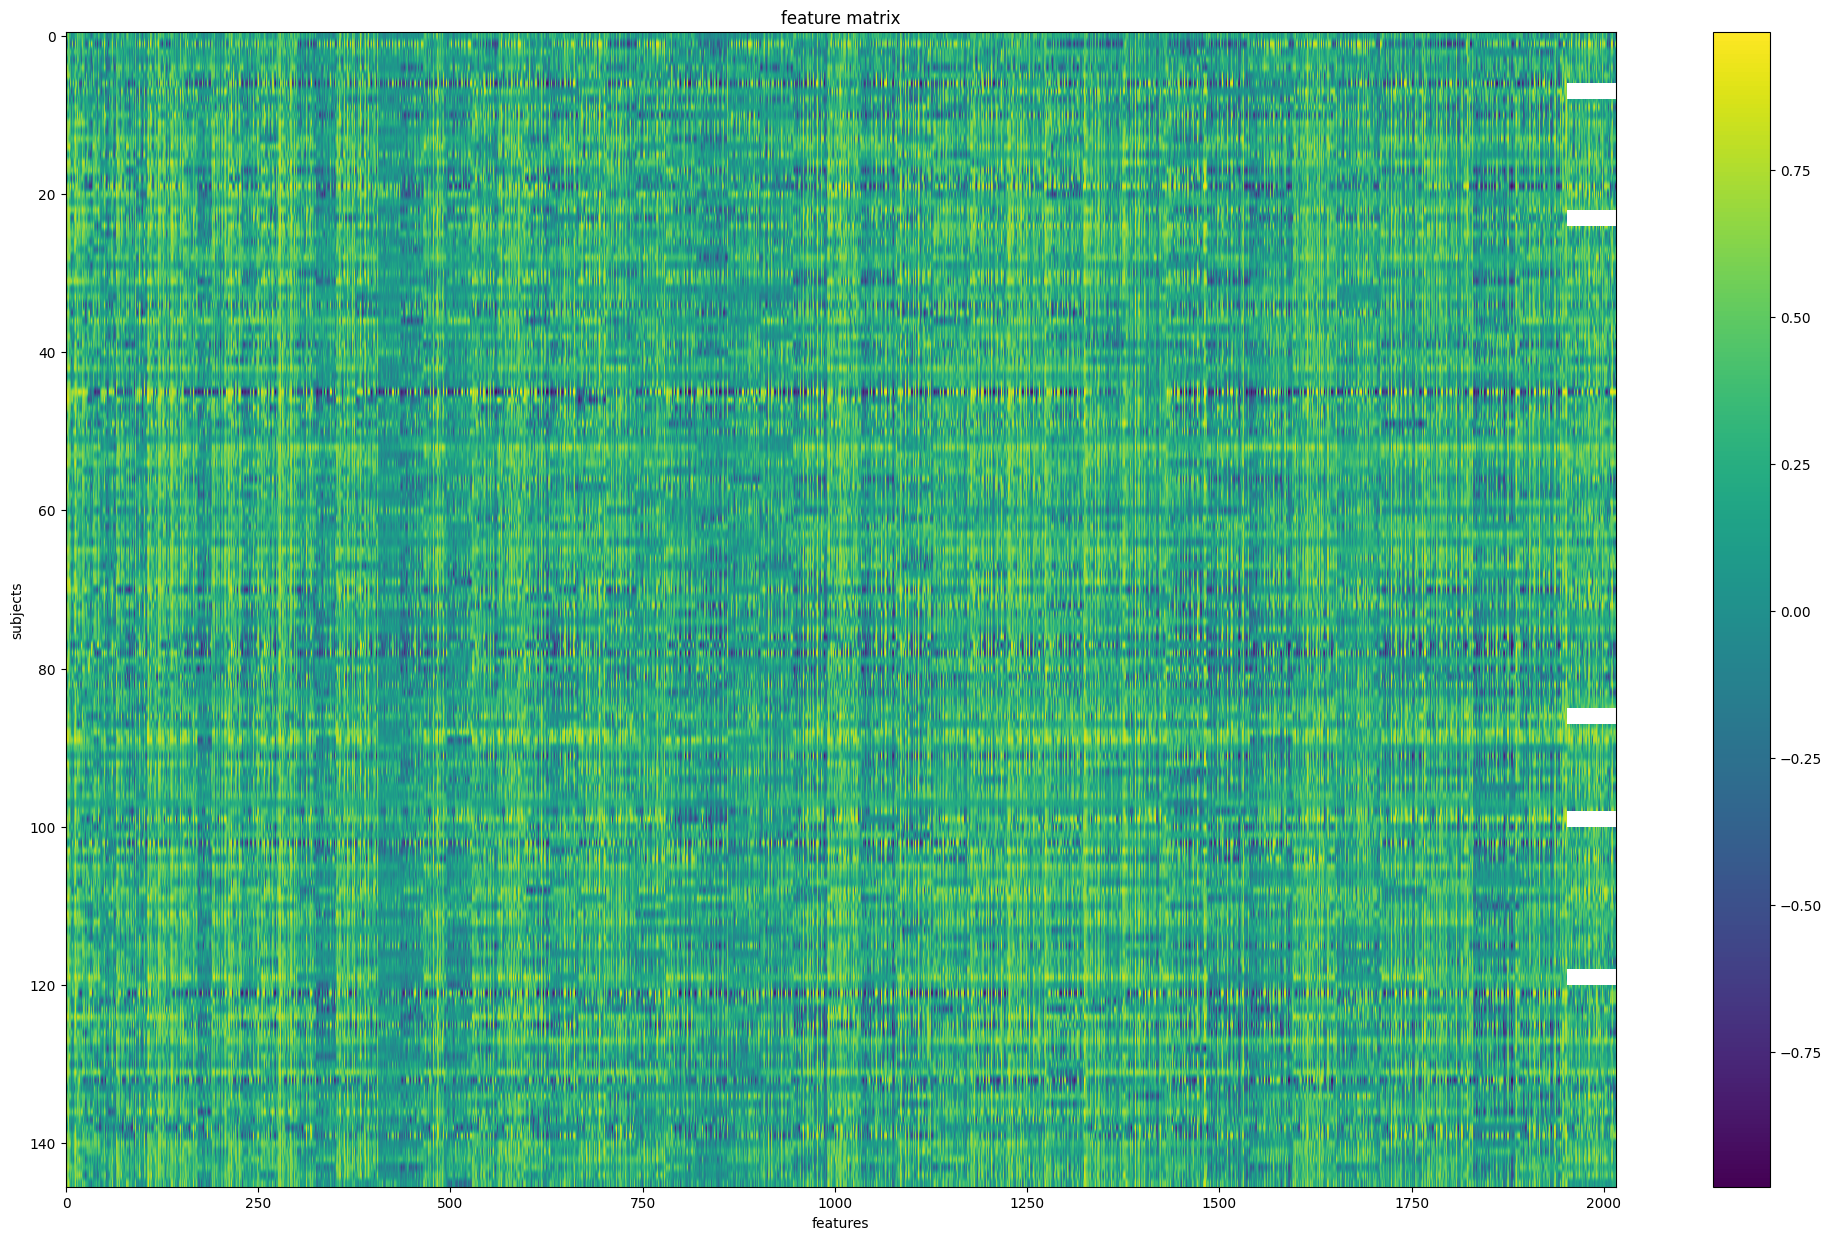

In [9]:
plt.imshow(X_features, aspect='auto')
plt.colorbar()
plt.title('feature matrix')
plt.xlabel('features')
plt.ylabel('subjects')

plt.gcf().set_size_inches(25, 15)

Removing incomplete records

In [10]:
xt1=Xt

xt1['y']=y_target
xt1['age']=age
xt1['sex']=sex
xt1=xt1.dropna()
xt1.to_csv(os.path.join(path+'\\Data\\COBRE\\', 'demo.csv'))
y_target=xt1['y']
age=xt1['age']
sex=xt1['sex']


xt1 = xt1.drop(['y','age','sex'],axis=1)
print(len(y_target), len(xt1))

141 141


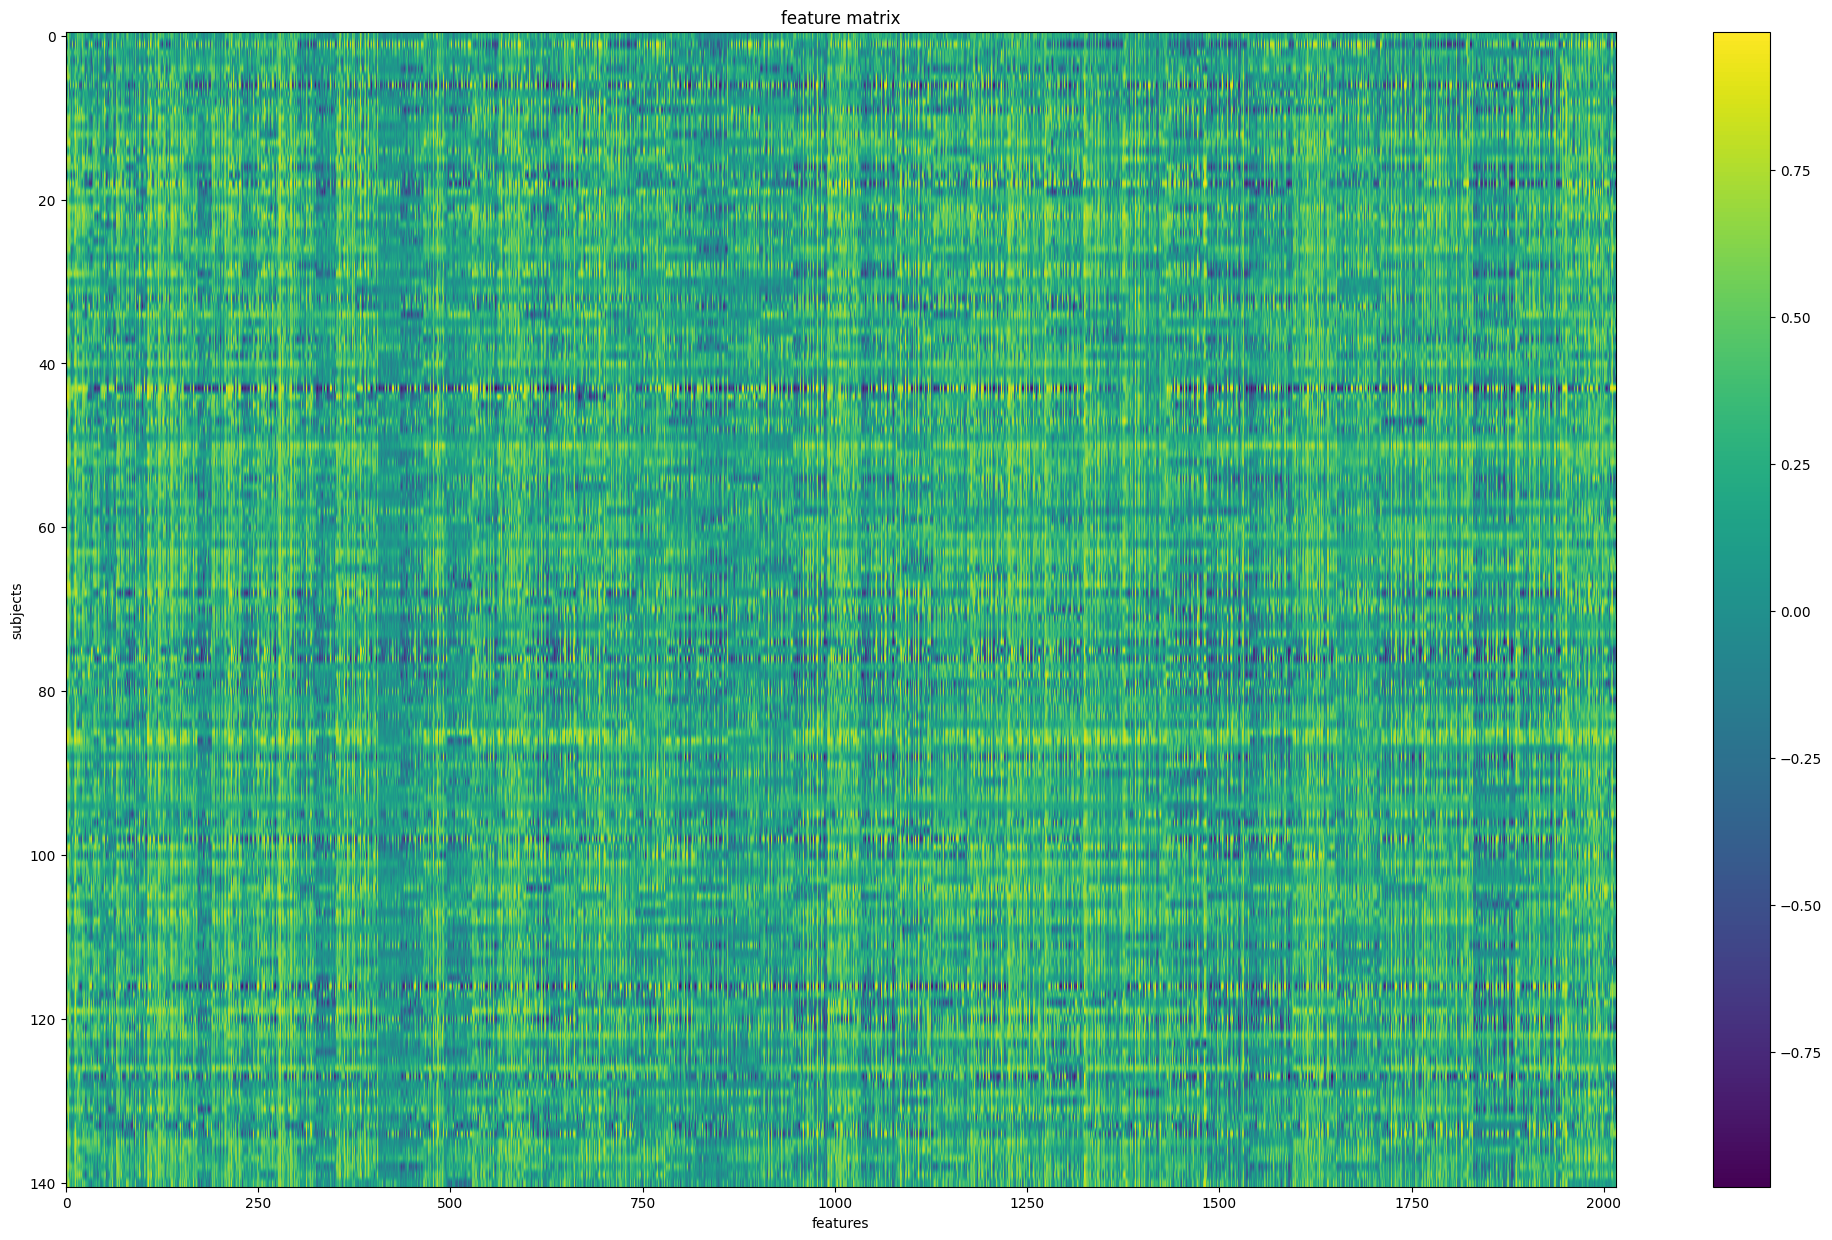

In [11]:
plt.imshow(xt1, aspect='auto')
plt.colorbar()
plt.title('feature matrix')
plt.xlabel('features')
plt.ylabel('subjects')

plt.gcf().set_size_inches(25, 15)